# Movie Review Bombing: Rotten Tomatoes Critic vs. Audience Score
# Rahul Rajeev

**Introduction:** Rotten Tomatoes stands out as the premier platform for critic reviews, and for that reason, most people tend to believe the critic scores over watching and judging the movies for themselves. I am sometimes one of those gullible people although for only movies that I am not very invested in. Because of this reason, I believe critics can "review bomb" because they have viewing parties and review the movie before the official release. This project will try to compare predicted audience scores and critic scores based on additional parameters. 

I will train the model based on parameters the audience may know as public knowledge to predict audience scores, and for critic scores, I will include additional parameters because the other criteria would matter. For example, the director of a movie might place bias on a critic's review, but not for an audience review. For an audience member, the runtimeMinutes may matter but for critics it absolutely matters. Genre is a parameter known to both the audience and the critic. Creating models and training it on different parameters based on audience and critic knowledge may lead to an understanding of where critics give a score opposite to the expected one. 

Dataset: https://www.kaggle.com/datasets/andrezaza/clapper-massive-rotten-tomatoes-movies-and-reviews?select=rotten_tomatoes_movies.csv

The data is taken from a kaggle dataset updating quite recently and was said to be webscraped meticulously. There are some columns I could add, calculating the originalScore because it is given as a score, fraction of a number, so calculating a numerical value would be better to read into a model. I could also try to add a sentiment analysis score based on the method we used to get a better score than just positive vs. negative. Then later I can replace the columns with qualitative variables with dummy variables to read into the model better as well. Hopefully we will learn about more methods to replacing the qualitative variables with dummy variables other than using a scale from 1-infinity. Perhaps clustering would be a good method as well?

## Milestone 1: Data Selection and EDA

In [9]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import regex as re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [6]:
# reading the movie file
movies = pd.read_csv('rotten_tomatoes_movies.csv')
movies.head()

,id,title,audienceScore,tomatoMeter,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,writer,boxOffice,distributor,soundMix
0,space-zombie-bingo,Space Zombie Bingo!,50.0,NaN,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,George Ormrod,"George Ormrod,John Sabotta",NaN,NaN,NaN
1,the_green_grass,The Green Grass,NaN,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Tiffany Edwards,Tiffany Edwards,NaN,NaN,NaN
2,love_lies,"Love, Lies",43.0,NaN,NaN,NaN,NaN,NaN,120.0,Drama,Korean,"Park Heung-Sik,Heung-Sik Park","Ha Young-Joon,Jeon Yun-su,Song Hye-jin",NaN,NaN,NaN
3,the_sore_losers_1997,Sore Losers,60.0,NaN,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,John Michael McCarthy,John Michael McCarthy,NaN,NaN,NaN
4,dinosaur_island_2002,Dinosaur Island,70.0,NaN,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Will Meugniot,John Loy,NaN,NaN,NaN


In [7]:
# the parameters for the movies dataset
movies.columns

Index(['id', 'title', 'audienceScore', 'tomatoMeter', 'rating',
       'ratingContents', 'releaseDateTheaters', 'releaseDateStreaming',
       'runtimeMinutes', 'genre', 'originalLanguage', 'director', 'writer',
       'boxOffice', 'distributor', 'soundMix'],
      dtype='object')

In [8]:
# reviews
reviews = pd.read_csv('rotten_tomatoes_movie_reviews.csv')
reviews.head()

,id,reviewId,creationDate,criticName,isTopCritic,originalScore,reviewState,publicatioName,reviewText,scoreSentiment,reviewUrl
0,beavers,1145982,2003-05-23,Ivan M. Lincoln,False,3.5/4,fresh,Deseret News (Salt Lake City),Timed to be just long enough for most youngste...,POSITIVE,http://www.deseretnews.com/article/700003233/B...
1,blood_mask,1636744,2007-06-02,The Foywonder,False,1/5,rotten,Dread Central,It doesn't matter if a movie costs 300 million...,NEGATIVE,http://www.dreadcentral.com/index.php?name=Rev...
2,city_hunter_shinjuku_private_eyes,2590987,2019-05-28,Reuben Baron,False,NaN,fresh,CBR,The choreography is so precise and lifelike at...,POSITIVE,https://www.cbr.com/city-hunter-shinjuku-priva...
3,city_hunter_shinjuku_private_eyes,2558908,2019-02-14,Matt Schley,False,2.5/5,rotten,Japan Times,The film's out-of-touch attempts at humor may ...,NEGATIVE,https://www.japantimes.co.jp/culture/2019/02/0...
4,dangerous_men_2015,2504681,2018-08-29,Pat Padua,False,NaN,fresh,DCist,Its clumsy determination is endearing and some...,POSITIVE,http://dcist.com/2015/11/out_of_frame_dangerou...


In [9]:
# parameters for the reviews dataset
reviews.columns

Index(['id', 'reviewId', 'creationDate', 'criticName', 'isTopCritic',
       'originalScore', 'reviewState', 'publicatioName', 'reviewText',
       'scoreSentiment', 'reviewUrl'],
      dtype='object')

In [10]:
# merge datasets using pandas concat
merged = reviews.merge(movies, on = 'id', how = 'left')

In [11]:
merged.head()

,id,reviewId,creationDate,criticName,isTopCritic,originalScore,reviewState,publicatioName,reviewText,scoreSentiment,...,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,writer,boxOffice,distributor,soundMix
0,beavers,1145982,2003-05-23,Ivan M. Lincoln,False,3.5/4,fresh,Deseret News (Salt Lake City),Timed to be just long enough for most youngste...,POSITIVE,...,NaN,2011-06-21,30.0,Documentary,English,Stephen Low,NaN,NaN,NaN,NaN
1,blood_mask,1636744,2007-06-02,The Foywonder,False,1/5,rotten,Dread Central,It doesn't matter if a movie costs 300 million...,NEGATIVE,...,NaN,NaN,NaN,NaN,NaN,Unknown Director,NaN,NaN,NaN,NaN
2,city_hunter_shinjuku_private_eyes,2590987,2019-05-28,Reuben Baron,False,NaN,fresh,CBR,The choreography is so precise and lifelike at...,POSITIVE,...,NaN,NaN,NaN,NaN,NaN,Kenji Kodama,NaN,NaN,NaN,NaN
3,city_hunter_shinjuku_private_eyes,2558908,2019-02-14,Matt Schley,False,2.5/5,rotten,Japan Times,The film's out-of-touch attempts at humor may ...,NEGATIVE,...,NaN,NaN,NaN,NaN,NaN,Kenji Kodama,NaN,NaN,NaN,NaN
4,dangerous_men_2015,2504681,2018-08-29,Pat Padua,False,NaN,fresh,DCist,Its clumsy determination is endearing and some...,POSITIVE,...,NaN,NaN,NaN,NaN,NaN,Unknown Director,NaN,NaN,NaN,NaN


# Data Visualizations

First let's get some ideas about top genres and top directors and see how many movies were made in each. The most popular types of movies must have different effects on reviews from the audience and the critics.

C:\Users\rahul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of Genres')

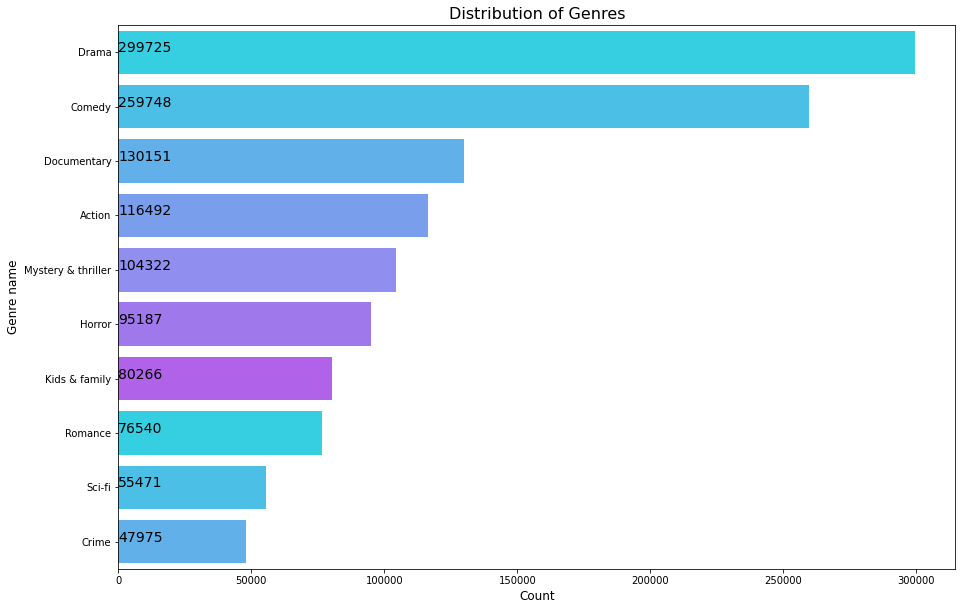

In [12]:
# creating a new column that pulls the first genre from the genre list usually present in the genre column
merged['first_genre'] = merged['genre'].str.split(',').str[0]

# cool map for colors
a = plt.cm.cool

# figure
plt.figure(figsize=(15,10))

# first 10 popular genres
count1 = merged['first_genre'].value_counts()[:10]

# barplot
sns.barplot(count1.values, count1.index, palette=[a(0.1),a(0.2),a(0.3),a(0.4),a(0.5),a(0.6),a(0.7)])

# displaying numbers
for i, v in enumerate(count1.values):
    plt.text(0.8,i,v,color='k',fontsize=14)

# labels
plt.xlabel('Count', fontsize=12)
plt.ylabel('Genre name', fontsize=12)
plt.title("Distribution of Genres", fontsize=16)

C:\Users\rahul\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of Directors')

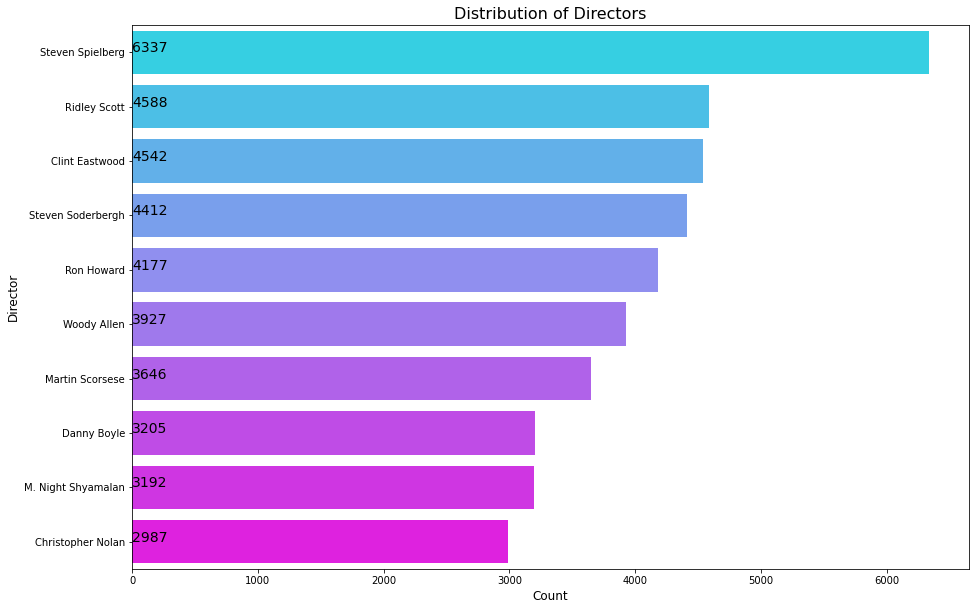

In [13]:
# getting top 10 directors
count2 = merged['director'].value_counts()[:10]

# figure
plt.figure(figsize=(15,10))

# bar plot
sns.barplot(count2.values, count2.index, palette=[a(0.1),a(0.2),a(0.3),a(0.4),a(0.5),a(0.6),a(0.7),a(0.8),a(0.9),a(0.99)])

# text labels for bar graph
for i, v in enumerate(count2.values):
    plt.text(0.8,i,v,color='k',fontsize=14)

# graph labels
plt.xlabel('Count', fontsize=12)
plt.ylabel('Director', fontsize=12)
plt.title("Distribution of Directors", fontsize=16)

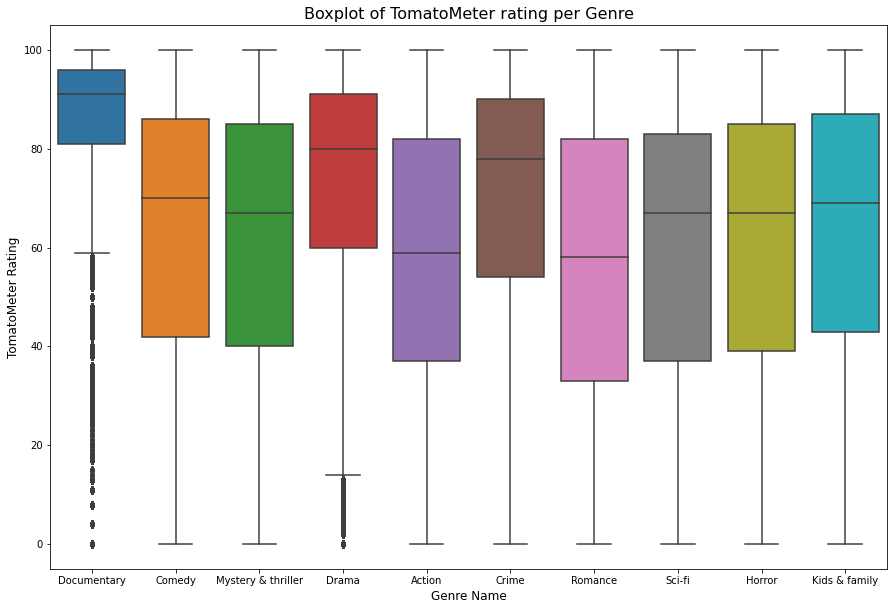

In [14]:
# creating a dataframe with the first genre, tomato meter, and audience score to gather more info about critic vs audience 
# score per genre

top_genres = list(count1.index)
top_genres_df = merged[merged['first_genre'].isin(top_genres)]

top_genres_df = top_genres_df[pd.notnull(top_genres_df[['first_genre', 'tomatoMeter', 
                                                              'audienceScore']])]

# boxplot figure for first genre and tomato meter
plt.figure(figsize=(15, 10))
sns.boxplot(x='first_genre', y='tomatoMeter', data=top_genres_df)
plt.xlabel("Genre Name",fontsize=12)
plt.ylabel("TomatoMeter Rating",fontsize=12)
plt.title("Boxplot of TomatoMeter rating per Genre", fontsize=16)
plt.show()

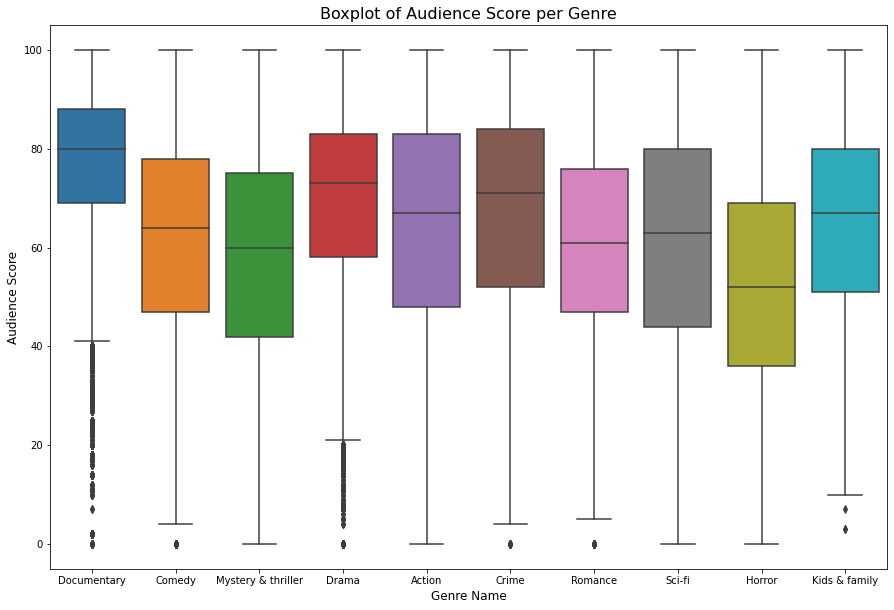

In [15]:
# figure for top genres and audience scores
plt.figure(figsize=(15, 10))
sns.boxplot(x='first_genre', y='audienceScore', data=top_genres_df)
plt.xlabel("Genre Name",fontsize=12)
plt.ylabel("Audience Score",fontsize=12)
plt.title("Boxplot of Audience Score per Genre", fontsize=16)
plt.show()

**Data Visualization insights:** The top genres are documentary, comedies, mysteries and thrillers, drama, action, crime, romance, sci-fi, horror, and kids and family. The other genres are most likely mixes of multiple genres, which is harder to categorize. The bar graph of top directors are also shown, and top directors usually have critics divisive on new projects. So looking at top directors I have an idea of who they are. Steven Spielberg is definitely known for his directing so movies from him will most likely have high scores from both the audience and critics. The next two boxplots show the distribution of scores from audience and critics from each genre. It is a bit apparent that audience scores are more tightly packed compared to critic scores as critics are more knowledgeable about each genre including information about directors and writers. They are aware of the strengths and weaknesses of the people that make the movies and therefore deliver the truth more harshly. Audiences are more interested in the movie itself, and therefore seem to clump around each other.

# Milestone 2: Data Preparation

In [16]:
merged.columns

Index(['id', 'reviewId', 'creationDate', 'criticName', 'isTopCritic',
       'originalScore', 'reviewState', 'publicatioName', 'reviewText',
       'scoreSentiment', 'reviewUrl', 'title', 'audienceScore', 'tomatoMeter',
       'rating', 'ratingContents', 'releaseDateTheaters',
       'releaseDateStreaming', 'runtimeMinutes', 'genre', 'originalLanguage',
       'director', 'writer', 'boxOffice', 'distributor', 'soundMix',
       'first_genre'],
      dtype='object')

We should drop reviewId, creationDate, criticName, reviewUrl, title, releaseDateTheaters, releaseDateStreaming, originalLanguage because they won't have much effect on the model or for EDA. I will also delete the original genre column because it is easier to use the first genre as a parameter rather than a list of genres. Rating contents has too many possibilities, and the genre column has too many possibilities so I will also drop those. Dropping the original score column as it has too many errors. Instead, the score will be replaced by the sentiment score from the reviewText column.

In [17]:
# drop some unimportant columns
merged2 = merged.drop(['reviewId', 'creationDate', 'criticName', 'reviewUrl', 'title', 'releaseDateTheaters', 
                       'releaseDateStreaming', 'originalLanguage', 'genre', 'ratingContents','originalScore'], axis=1)

In [18]:
merged2.head()

,id,isTopCritic,reviewState,publicatioName,reviewText,scoreSentiment,audienceScore,tomatoMeter,rating,runtimeMinutes,director,writer,boxOffice,distributor,soundMix,first_genre
0,beavers,False,fresh,Deseret News (Salt Lake City),Timed to be just long enough for most youngste...,POSITIVE,75.0,NaN,NaN,30.0,Stephen Low,NaN,NaN,NaN,NaN,Documentary
1,blood_mask,False,rotten,Dread Central,It doesn't matter if a movie costs 300 million...,NEGATIVE,NaN,NaN,NaN,NaN,Unknown Director,NaN,NaN,NaN,NaN,NaN
2,city_hunter_shinjuku_private_eyes,False,fresh,CBR,The choreography is so precise and lifelike at...,POSITIVE,NaN,NaN,NaN,NaN,Kenji Kodama,NaN,NaN,NaN,NaN,NaN
3,city_hunter_shinjuku_private_eyes,False,rotten,Japan Times,The film's out-of-touch attempts at humor may ...,NEGATIVE,NaN,NaN,NaN,NaN,Kenji Kodama,NaN,NaN,NaN,NaN,NaN
4,dangerous_men_2015,False,fresh,DCist,Its clumsy determination is endearing and some...,POSITIVE,42.0,50.0,NaN,NaN,Unknown Director,NaN,NaN,NaN,NaN,NaN


In [19]:
# lets drop the rows where both audience score and tomatoMeter are NA, because those are going to be our target values
merged3 = merged2.dropna(how='all', subset=['audienceScore','tomatoMeter'])
print('Before:', merged2.shape, 'After:', merged3.shape)

Before: (1469840, 16) After: (1437875, 16)


In [20]:
merged3

,id,isTopCritic,reviewState,publicatioName,reviewText,scoreSentiment,audienceScore,tomatoMeter,rating,runtimeMinutes,director,writer,boxOffice,distributor,soundMix,first_genre
0,beavers,False,fresh,Deseret News (Salt Lake City),Timed to be just long enough for most youngste...,POSITIVE,75.0,NaN,NaN,30.0,Stephen Low,NaN,NaN,NaN,NaN,Documentary
4,dangerous_men_2015,False,fresh,DCist,Its clumsy determination is endearing and some...,POSITIVE,42.0,50.0,NaN,NaN,Unknown Director,NaN,NaN,NaN,NaN,NaN
5,dangerous_men_2015,False,fresh,Lawrence.com,"With every new minute, there's another head-sc...",POSITIVE,42.0,50.0,NaN,NaN,Unknown Director,NaN,NaN,NaN,NaN,NaN
6,dangerous_men_2015,False,fresh,We Got This Covered,"Emotionless reaction shots, zero characterizat...",POSITIVE,42.0,50.0,NaN,NaN,Unknown Director,NaN,NaN,NaN,NaN,NaN
7,dangerous_men_2015,True,rotten,Boston Globe,"Conceivably, it could serve as a primer for st...",NEGATIVE,42.0,50.0,NaN,NaN,Unknown Director,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469835,thor_love_and_thunder,False,fresh,Raising Whasians,Solid but not totally sold&#44; Thor&#58; Ragn...,POSITIVE,77.0,63.0,PG-13,125.0,Taika Waititi,"Taika Waititi,Jennifer Kaytin Robinson",$343.2M,Walt Disney Pictures,"Dolby Digital, Dolby Atmos",Action
1469836,thor_love_and_thunder,False,fresh,Digital Spy,Thor&#58; Love and Thunder is the most enterta...,POSITIVE,77.0,63.0,PG-13,125.0,Taika Waititi,"Taika Waititi,Jennifer Kaytin Robinson",$343.2M,Walt Disney Pictures,"Dolby Digital, Dolby Atmos",Action
1469837,thor_love_and_thunder,False,fresh,Next Best Picture,&quot;Thor&#58; Love and Thunder&quot; is a st...,POSITIVE,77.0,63.0,PG-13,125.0,Taika Waititi,"Taika Waititi,Jennifer Kaytin Robinson",$343.2M,Walt Disney Pictures,"Dolby Digital, Dolby Atmos",Action
1469838,thor_love_and_thunder,True,rotten,Slant Magazine,Across Taika Waititi&#8217;s film&#44; a war a...,NEGATIVE,77.0,63.0,PG-13,125.0,Taika Waititi,"Taika Waititi,Jennifer Kaytin Robinson",$343.2M,Walt Disney Pictures,"Dolby Digital, Dolby Atmos",Action


In [21]:
import regex as re
# replacing originalScore column sentiment score of review
# data transformations

# lower case
merged3['reviewText'] = merged3['reviewText'].str.lower()

# regex
merged3['reviewText'] = merged3['reviewText'].apply(lambda x: re.sub('[^A-Za-z0-9]', ' ', str(x)))

# stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
merged3['review_without_stopwords'] = merged3['reviewText'].apply(lambda x: ' '.join(
    [word for word in x.split() if word not in (stop)]))

# stemmed
stemmer = PorterStemmer()

def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

# creating stemmed column with the results
merged3['stemmed'] = merged3['review_without_stopwords'].apply(stem_sentences)

<ipython-input-21-0eeccf5c8816>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged3['reviewText'] = merged3['reviewText'].str.lower()
<ipython-input-21-0eeccf5c8816>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged3['reviewText'] = merged3['reviewText'].apply(lambda x: re.sub('[^A-Za-z0-9]', ' ', str(x)))
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-21-0eeccf5c8816>:1

In [22]:
# getting polarity score
from textblob import TextBlob

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

merged3['Polarity'] = merged3['stemmed'].apply(getPolarity)

<ipython-input-22-bbbf5364552d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged3['Polarity'] = merged3['stemmed'].apply(getPolarity)


In [23]:
merged4 = merged3.drop(['reviewText', 'scoreSentiment', 'review_without_stopwords', 'stemmed', 'boxOffice'], axis=1)
merged4copy = merged4.copy()

Here I dropped the text columns, the sentiment column, and the boxoffice column which I forgot to drop earlier. The text ones are obviously dropped because they can't be used in machine learning. The boxoffice is dropped because it represents a results after the reviews are in, not before, so it doesn't make sense to keep it.

In [24]:
merged4

,id,isTopCritic,reviewState,publicatioName,audienceScore,tomatoMeter,rating,runtimeMinutes,director,writer,distributor,soundMix,first_genre,Polarity
0,beavers,False,fresh,Deseret News (Salt Lake City),75.0,NaN,NaN,30.0,Stephen Low,NaN,NaN,NaN,Documentary,-0.016667
4,dangerous_men_2015,False,fresh,DCist,42.0,50.0,NaN,NaN,Unknown Director,NaN,NaN,NaN,NaN,0.000000
5,dangerous_men_2015,False,fresh,Lawrence.com,42.0,50.0,NaN,NaN,Unknown Director,NaN,NaN,NaN,NaN,0.195455
6,dangerous_men_2015,False,fresh,We Got This Covered,42.0,50.0,NaN,NaN,Unknown Director,NaN,NaN,NaN,NaN,0.485714
7,dangerous_men_2015,True,rotten,Boston Globe,42.0,50.0,NaN,NaN,Unknown Director,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469835,thor_love_and_thunder,False,fresh,Raising Whasians,77.0,63.0,PG-13,125.0,Taika Waititi,"Taika Waititi,Jennifer Kaytin Robinson",Walt Disney Pictures,"Dolby Digital, Dolby Atmos",Action,0.333333
1469836,thor_love_and_thunder,False,fresh,Digital Spy,77.0,63.0,PG-13,125.0,Taika Waititi,"Taika Waititi,Jennifer Kaytin Robinson",Walt Disney Pictures,"Dolby Digital, Dolby Atmos",Action,0.093750
1469837,thor_love_and_thunder,False,fresh,Next Best Picture,77.0,63.0,PG-13,125.0,Taika Waititi,"Taika Waititi,Jennifer Kaytin Robinson",Walt Disney Pictures,"Dolby Digital, Dolby Atmos",Action,0.500000
1469838,thor_love_and_thunder,True,rotten,Slant Magazine,77.0,63.0,PG-13,125.0,Taika Waititi,"Taika Waititi,Jennifer Kaytin Robinson",Walt Disney Pictures,"Dolby Digital, Dolby Atmos",Action,-0.700000


At this point, I don't really know how to deal with the many different categories that exist for each of the columns, and what type of encoding works best. If I could get any suggestions about this I would gladly appreciate it. 

In [25]:
# encoding labels for the remaining string columns instead of dummy because there would simply be too many columns
objList = merged4.select_dtypes(include = "object").columns
print (objList)

Index(['id', 'reviewState', 'publicatioName', 'rating', 'director', 'writer',
       'distributor', 'soundMix', 'first_genre'],
      dtype='object')


In [26]:
# creating encoder
le = LabelEncoder()

In [27]:
# applying to columns in string list
for feat in objList[1:]:
    merged4[feat] = le.fit_transform(merged4[feat].astype(str))

In [28]:
merged4

,id,isTopCritic,reviewState,publicatioName,audienceScore,tomatoMeter,rating,runtimeMinutes,director,writer,distributor,soundMix,first_genre,Polarity
0,beavers,False,0,622,75.0,NaN,8,30.0,22072,30473,3036,536,7,-0.016667
4,dangerous_men_2015,False,0,557,42.0,50.0,8,NaN,23744,30473,3036,536,28,0.000000
5,dangerous_men_2015,False,0,1261,42.0,50.0,8,NaN,23744,30473,3036,536,28,0.195455
6,dangerous_men_2015,False,0,2549,42.0,50.0,8,NaN,23744,30473,3036,536,28,0.485714
7,dangerous_men_2015,True,1,233,42.0,50.0,8,NaN,23744,30473,3036,536,28,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469835,thor_love_and_thunder,False,0,1781,77.0,63.0,2,125.0,22604,27718,2871,118,0,0.333333
1469836,thor_love_and_thunder,False,0,634,77.0,63.0,2,125.0,22604,27718,2871,118,0,0.093750
1469837,thor_love_and_thunder,False,0,1590,77.0,63.0,2,125.0,22604,27718,2871,118,0,0.500000
1469838,thor_love_and_thunder,True,1,1992,77.0,63.0,2,125.0,22604,27718,2871,118,0,-0.700000


**Results of Milestone 2:** So in the end, I am left with the important columns, of which the string ones are label encoded. If I were to use dummy variables instead, you would see that there would be almost 30473 columns for writers which isn't wise. At least with label encoding, I could reduce dimensionality, but in the process of doing so, lose significance of one writer to another. I believe that if the machine learning model isn't benefitted by the publication name, director, writer, distributor, or soundMix columns, I could definitely throw those columns out. Everything else such as topcritic, reviewstate, the scores, rating, runtime, first_genre, and polarity can stay. 

As far as the two models I plan to run are:
1. To predict audience score, I will use the rating, runtime, first_genre.
2. To predict critic score, I will use all of the previous features and add on istopcritic, reviewstate, director, writer, distributor, soundmix, and polarity to keep track of the reviews.

Additional transformation steps could be dropping all rows with missing values in runtime, director, writer, distributor, soundmix, and first_genre.

# Milestone 3: Model Building and Evaluation

======================================================================================================================
## 1. Predicting Audience Rating
As planned, I will predict audience score using rating, runtime, first_genre. There shouldn't be much issue with 
using features here because the columns have a limited number of categories and range. As opposed to the much more 
challenging prediction of critic score.

To simplify the prediction process since predicting an exact audience score percentage, I will instead replace the 
scores with the text displayed with a particular range of the score. The transformation function along with the 
dictionary of values to be replaced with are shown below.

======================================================================================================================

In [20]:
# mapping review value ranges to status of the entire movie
def get_rating(var_name, value):
    the_ranges = {
        'audienceScore': [
            (0,  61, 'tipped'),
            (61,  101, 'upright'),
        ],
        'tomatoMeter': [
            (0,  61, 'rotten'),
            (61,  101, 'fresh'),
        ],
    }

    for v_min, v_max, rating in the_ranges[var_name]:
        if v_min <= value <= v_max:
            return rating

    raise ValueError('nothing found for {} and value {}'.format(var_name, value))


In [9]:
get_rating('audienceScore', 75)

'upright'

In [21]:
final['audienceRating'] = np.NaN
final['tomatoRating'] = np.NaN
for i, val in enumerate(final['audienceScore']):
    #print(i)
    final['audienceRating'][i] = get_rating('audienceScore', val)
    final['tomatoRating'][i] = get_rating('tomatoMeter', final['tomatoMeter'][i])

<ipython-input-21-e9f6cf55b4f5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['audienceRating'][i] = get_rating('audienceScore', val)
C:\Users\rahul\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-21-e9f6cf55b4f5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['tomatoRating'][i] = get_rating('tomatoMeter', f

In [28]:
final2 = final.drop(['Unnamed: 0', 'id','audienceScore', 'tomatoMeter'], axis=1)
final2

,isTopCritic,reviewState,publicatioName,rating,runtimeMinutes,director,writer,distributor,soundMix,first_genre,Polarity,audienceRating,tomatoRating
0,False,rotten,The List,R,100.0,John Simpson,John Simpson,First Look,"Surround, Dolby Digital",Mystery & thriller,0.000000,tipped,fresh
1,True,fresh,Los Angeles Times,R,100.0,John Simpson,John Simpson,First Look,"Surround, Dolby Digital",Mystery & thriller,0.000000,tipped,fresh
2,True,fresh,L.A. Weekly,R,100.0,John Simpson,John Simpson,First Look,"Surround, Dolby Digital",Mystery & thriller,0.000000,tipped,fresh
3,False,fresh,ViewLondon,R,100.0,John Simpson,John Simpson,First Look,"Surround, Dolby Digital",Mystery & thriller,0.000000,tipped,fresh
4,True,rotten,BBC.com,R,100.0,John Simpson,John Simpson,First Look,"Surround, Dolby Digital",Mystery & thriller,0.000000,tipped,fresh
...,...,...,...,...,...,...,...,...,...,...,...,...,...
490545,False,fresh,Raising Whasians,PG-13,125.0,Taika Waititi,"Taika Waititi,Jennifer Kaytin Robinson",Walt Disney Pictures,"Dolby Digital, Dolby Atmos",Action,0.333333,upright,fresh
490546,False,fresh,Digital Spy,PG-13,125.0,Taika Waititi,"Taika Waititi,Jennifer Kaytin Robinson",Walt Disney Pictures,"Dolby Digital, Dolby Atmos",Action,0.093750,upright,fresh
490547,False,fresh,Next Best Picture,PG-13,125.0,Taika Waititi,"Taika Waititi,Jennifer Kaytin Robinson",Walt Disney Pictures,"Dolby Digital, Dolby Atmos",Action,0.500000,upright,fresh
490548,True,rotten,Slant Magazine,PG-13,125.0,Taika Waititi,"Taika Waititi,Jennifer Kaytin Robinson",Walt Disney Pictures,"Dolby Digital, Dolby Atmos",Action,-0.700000,upright,fresh


In [49]:
#final2.to_csv('reviews_final2.csv')
final2 = pd.read_csv('reviews_final2.csv')

In [50]:
# getting dummy columns
audiencecol = ['runtimeMinutes','rating', 'first_genre']
audience_with_dum = pd.get_dummies(final2[audiencecol], columns = audiencecol[1:])
audience_with_dum['audienceRating'] = final2['audienceRating']

# split data for audience rating
X_aud = audience_with_dum.drop(['audienceRating'], axis=1)
Y_aud = audience_with_dum['audienceRating']
X_aud_train, X_aud_test, Y_aud_train, Y_aud_test = train_test_split(X_aud, Y_aud, test_size=0.2)

In [51]:
audience_with_dum

,runtimeMinutes,rating_NC-17,rating_PG,rating_PG-13,rating_R,rating_TVPG,first_genre_Action,first_genre_Adventure,first_genre_Biography,first_genre_Comedy,...,first_genre_Holiday,first_genre_Horror,first_genre_Kids & family,first_genre_Musical,first_genre_Mystery & thriller,first_genre_Romance,first_genre_Sci-fi,first_genre_War,first_genre_Western,audienceRating
0,100.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,tipped
1,100.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,tipped
2,100.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,tipped
3,100.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,tipped
4,100.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,tipped
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490545,125.0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,upright
490546,125.0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,upright
490547,125.0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,upright
490548,125.0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,upright


**Model Selection** 

As an initial dive into the data, I will try three different binary classification models:
1. Logistic Regression
2. K Neighbors Classifier
3. Decision Tree

In addition, I will run it through a grid search with crossvalidation to ensure the best model along with hyperparameters possible. 

**Note:** I tried SVM and nothing seemed to work, it required too much power, and the time required seemed to be indefinite, so I excluded it from the models to be tried.

In [6]:
# logistic regression, no scaling, and no grid search
logistic = LogisticRegression()

logistic.fit(X_aud_train, Y_aud_train)
logistic.score(X_aud_test, Y_aud_test)

C:\Users\rahul\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6844154520436245

With no extra adjustments in hyperparameters, the model's accuracy is currently about 69%. Now, I will attempt to scale the data and get more information about the best model. I should also try other models and see whether I can get better results.

In [7]:
# scaler
scaler = StandardScaler()

# pipe
pipe = Pipeline(steps = [('scaler', scaler),('classifier', logistic)])

search_space = [{'classifier__C': np.logspace(0,4,10),
                   'classifier__penalty': ['l1', 'l2']}]

# grid cv
grid_classifier = GridSearchCV(pipe, search_space, cv=5).fit(X_aud_train, Y_aud_train)

C:\Users\rahul\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rahul\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rahul\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 406, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\rahul\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py",

In [8]:
grid_classifier.score(X_aud_test, Y_aud_test)

0.6867189888900214

The accuracy hasn't changed much, so we will move on to the next model, using K Neighbors.

In [18]:
# trying KNN
pipe2 = Pipeline(steps = [('scaler', scaler),('classifier', KNeighborsClassifier())])

search_space2 = [{'classifier__n_neighbors':list(range(1,11))}]

# grid cv
grid_classifier2 = GridSearchCV(pipe2, search_space2, cv=5, verbose = 1).fit(X_aud_train, Y_aud_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [19]:
grid_classifier2.score(X_aud_test, Y_aud_test)

0.7988074610131485

Text(0.5, 1.0, 'Scores vs. K Neighbors')

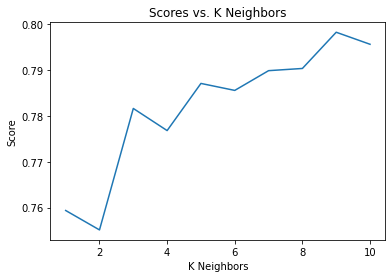

In [24]:
plt.plot(range(1,11), grid_classifier2.cv_results_['mean_test_score'])
plt.xlabel('K Neighbors')
plt.ylabel('Score')
plt.title('Scores vs. K Neighbors')
#grid_classifier2.cv_results_['mean_test_score']

In [20]:
grid_classifier2.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('classifier', KNeighborsClassifier(n_neighbors=9))],
 'verbose': False,
 'scaler': StandardScaler(),
 'classifier': KNeighborsClassifier(n_neighbors=9),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'classifier__algorithm': 'auto',
 'classifier__leaf_size': 30,
 'classifier__metric': 'minkowski',
 'classifier__metric_params': None,
 'classifier__n_jobs': None,
 'classifier__n_neighbors': 9,
 'classifier__p': 2,
 'classifier__weights': 'uniform'}

I found a much higher accuracy with KNN and the model doesn't seem to be overfitting the data as the accuracy is increasing the more complex we make teh model. The best estimator's params state that we used up to 9 neighbors. I could continue to check what the most optimal hyperparameters would be following this, but since the computation size and time would take exceptionally longer, I have stopped my search here.

However, it might also be worthwhile just to check out the Decision Tree Classifier.

In [15]:
# trying Decision Tree
pipe3 = Pipeline(steps = [('scaler', scaler),('classifier', DecisionTreeClassifier())])

search_space3 = [{'classifier__max_depth':list(range(1,6))}]

# grid cv
grid_classifier3 = GridSearchCV(pipe3, search_space3, cv=5, verbose = 1).fit(X_aud_train, Y_aud_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [16]:
grid_classifier3.score(X_aud_test, Y_aud_test)

0.6883396187952299

Decision Tree Classifier seems to have around the same accuracy as logistic regression, so the model I will be sticking with will be KNN.

In [ ]:
# trying svm
scaler = StandardScaler()
pipe4 = Pipeline(steps = [('scaler', scaler),('classifier', SVC())])

search_space4 = [{'classifier__C': [0.1, 1], 
              'classifier__gamma': [1, 0.1],
              'classifier__kernel': ['rbf']}]

# grid cv
grid_classifier4 = GridSearchCV(pipe4, search_space4, cv=5, verbose = 1).fit(X_aud_train, Y_aud_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


SVM is too CPU heavy for my computer alone to handle, so I will not work with the model.

======================================================================================================================
## 2. Predicting Tomato Rating
For the second portion of the project, I will attempt to predict tomato rating based on factors about the movie that the 
critic may be concerned about. I will transform more of the data to work well. Since there are many unique values in a lot of the categorical columns I am going to be using in the model, I will try to use the following method.

To deal with the new categorical columns for the tomato rating prediction, I will find the most frequent values and set the 
top ones to be categories, and setting the rest less frequent ones to be others. That way I have less unique values and less columns created when using dummy variables and passing it into the model.

======================================================================================================================

**Publication Name**

Starting with publication name, the reviews are all pretty close together, so it's hard to determine which ones will be the most frequent. I think maybe the right way to approach this particular feature is to replace the publication names with categories where the publication has more than 2500 reviews, more than 2000 reviews, more than 1500 reviews, more than 1000, and then more than 500 reviews. The rest should be set to other category. Hopefully this is a fair partioning for reviews. This will reduce the unique values.

In [91]:
final2['publicatioName'].value_counts()

Washington Post          3456
New York Times           3214
eFilmCritic.com          3153
Austin Chronicle         2995
Reeling Reviews          2945
                         ... 
2 Minute Telly              1
In Contention               1
JurgenFauth.com             1
Spirituality & Health       1
Lansing City Pulse          1
Name: publicatioName, Length: 2355, dtype: int64

In [92]:
def get_category(var_name, value):
    the_ranges = {
        'pubcount': [
            (0,  500, '0'),
            (500,  1000, '1'),
            (1000,  1500, '2'),
            (1500,  2000, '3'),
            (2000,  2500, '4'),
            (2500,  3000, '5'),
            (3000,  3500, '6'),
        ],
        'directorcount': [
            (0,  1000, '0'),
            (1000,  2000, '1'),
            (2000,  3000, '2'),
            (3000,  4000, '3'),
            (4000,  5000, '4'),
            (5000,  6000, '5'),     
        ],
        'writercount': [
            (0,  500, '0'),
            (500,  1000, '1'),
            (1000,  1500, '2'),
            (1500,  2000, '3'),
            (2000,  2500, '4'),
        ],
        'distributorcount': [
            (0,  1000, '0'),
            (1000,  5000, '1'),
            (5000,  10000, '2'),
            (10000,  20000, '3'),
            (20000,  60000, '4'),
        ],
    }

    for v_min, v_max, rating in the_ranges[var_name]:
        if v_min <= value <= v_max:
            return rating

    raise ValueError('nothing found for {} and value {}'.format(var_name, value))

In [67]:
# creating a frequency column
pub_cat=[]
final2['pubcount'] = final2.groupby('publicatioName')['publicatioName'].transform('count')

# replacing frequencies using the translation dictionary based on parameters I chose
for i, val in enumerate(final2['pubcount']):
    #print(i)
    pub_cat.append(get_category('pubcount', val))

final2['pub_cat'] = pub_cat

**Directors**

Let's see if we can take a similar approach for directors.

In [53]:
final2['director'].value_counts()

Steven Spielberg      5097
Ridley Scott          3693
Christopher Nolan     2949
M. Night Shyamalan    2814
Peyton Reed           2788
                      ... 
Beth LaMure              5
Kyle Cooper              5
Lynne Stopkewich         4
Elliott Lester           4
Karin Julsrud            4
Name: director, Length: 1782, dtype: int64

Yes, so we can probably try the same thing, assign the frequency ranges to a category and have most popular directors down to least popular directors. I will use different ranges here however. I can do for every thousand count, meaning 4000-5000, 3000-4000, since the reviews are much more spaced out. I will include the translation dictionary to the get_category function, and perform the exact same code as before for the publication name.

**Quick Check:** But why might it be ok do this? I believe if a director appears more frequently in the movie reviews, it makes sense that critics are more willing to watch the movie, therefore provide their input, and then change the tomato rating itself. Otherwise, they may be less inclined to do so. 

In [68]:
# creating a frequency column
director_cat=[]
final2['directorcount'] = final2.groupby('director')['director'].transform('count')

# replacing frequencies using the translation dictionary based on parameters I chose
for i, val in enumerate(final2['directorcount']):
    #print(i)
    director_cat.append(get_category('directorcount', val))


final2['director_cat'] = director_cat

**Writers**

Next is the writers column.

In [85]:
final2['writer'].value_counts()[:10]

M. Night Shyamalan                    2280
Christopher Markus,Stephen McFeely    2062
Alex Garland                          1977
Bong Joon Ho,Han Jinwon               1908
Joel Coen,Ethan Coen                  1796
Paul Thomas Anderson                  1659
Jeff Loveness                         1520
Aaron Sorkin                          1462
Simon Kinberg                         1409
Quentin Tarantino                     1389
Name: writer, dtype: int64

Similar to publications, the numbers are alot more closer, so I will have to create ranges for the categories here. I will most likely use similar ranges to publication count, maybe even smaller intervals, since the most frequent value only goes up to 2280 frequency. 

In [78]:
# creating a frequency column
writer_cat=[]
final2['writercount'] = final2.groupby('writer')['writer'].transform('count')

# replacing frequencies using the translation dictionary based on parameters I chose
for i, val in enumerate(final2['writercount']):
    #print(i)
    writer_cat.append(get_category('writercount', val))


final2['writer_cat'] = writer_cat

**Distributor**

Next is the distributors column.

In [93]:
final2['distributor'].value_counts()

Warner Bros. Pictures                                                                                                     55501
Universal Pictures                                                                                                        48946
20th Century Fox                                                                                                          37559
Paramount Pictures                                                                                                        36366
Sony Pictures Entertainment                                                                                               26032
                                                                                                                          ...  
Atlas Distribution Company                                                                                                    5
Phaedra Cinema, Artisan Entertainment                                                                   

The frequencies are very far apart, so I will have to adjust the dictionary accordingly. I would say, we can bucket into More than 20000, more than 10000, more than 5000, more than 1000, and the rest other.

In [94]:
# creating a frequency column
distributor_cat=[]
final2['distributorcount'] = final2.groupby('distributor')['distributor'].transform('count')

# replacing frequencies using the translation dictionary based on parameters I chose
for i, val in enumerate(final2['distributorcount']):
    #print(i)
    distributor_cat.append(get_category('distributorcount', val))


final2['distributor_cat'] = writer_cat

In [95]:
final2.head()

,Unnamed: 0,isTopCritic,reviewState,publicatioName,rating,runtimeMinutes,director,writer,distributor,soundMix,...,audienceRating,tomatoRating,pubcount,pub_cat,directorcount,director_cat,writercount,writer_cat,distributorcount,distributor_cat
0,0,False,rotten,The List,R,100.0,John Simpson,John Simpson,First Look,"Surround, Dolby Digital",...,tipped,fresh,1006,2,7,0,7,0,773,0
1,1,True,fresh,Los Angeles Times,R,100.0,John Simpson,John Simpson,First Look,"Surround, Dolby Digital",...,tipped,fresh,2830,5,7,0,7,0,773,0
2,2,True,fresh,L.A. Weekly,R,100.0,John Simpson,John Simpson,First Look,"Surround, Dolby Digital",...,tipped,fresh,1344,2,7,0,7,0,773,0
3,3,False,fresh,ViewLondon,R,100.0,John Simpson,John Simpson,First Look,"Surround, Dolby Digital",...,tipped,fresh,1522,3,7,0,7,0,773,0
4,4,True,rotten,BBC.com,R,100.0,John Simpson,John Simpson,First Look,"Surround, Dolby Digital",...,tipped,fresh,1513,3,7,0,7,0,773,0


**Sound Mix**

Last but not least, there is the Sound Mix column. Let's check it out.

In [123]:
final2['soundMix'].value_counts()

Dolby Digital                                                          82614
Dolby Atmos                                                            39118
Dolby SRD, DTS, SDDS                                                   32102
Dolby SR, DTS, Dolby Stereo, Surround, SDDS, Dolby A, Dolby Digital    21660
Surround                                                               17989
                                                                       ...  
Mono, Surround                                                            13
Surround, SDDS                                                            13
Dolby Stereo, Surround, SDDS                                               9
Dolby, Stereo                                                              8
Stereo, Dolby SR, Dolby Digital, Dolby A, Dolby Stereo                     7
Name: soundMix, Length: 349, dtype: int64

So the sound mix column is quite interesting because they all share the same attributes, its just that some movies are shown in a variety of sound mixes and other are more direct, as represented by the dominance of dolby digital. Dolby Atmos comes in a distant second. Here, I might want to switch up the category attribution. Let's say that if a movie is offered in one form, then it would be category 0, then if it's offered in two forms, then the category is 1, and so on and so forth. That way it's not exactly about the sound mix, more about the versatility of the movie. I think this might be a fair approach.

In [110]:
# to count the elements, instead of stripping and counting the string elements in a list, I could simply count the number of 
# commas in that string and add 1. 
# Source: https://stackoverflow.com/questions/41571591/count-the-number-of-elements-in-a-string-separated-by-comma
# pretty neat stuff

def get_sound_count(text):
    sound_count = text.count(',') + 1
    return str(sound_count)

final2['sound_count'] = final2['soundMix'].apply(get_sound_count)

Finally, after creating all the bucketed categorical columns, let's drop the original categorical columns and the temporary frequency columns I created so that we have a simple dataset.

In [111]:
final2.columns
final3 = final2.drop(['Unnamed: 0', 'publicatioName', 'director', 
                      'writer', 'distributor', 'soundMix', 'pubcount', 'directorcount',
                     'writercount', 'distributorcount'], axis=1)
final3.head(10)

,isTopCritic,reviewState,rating,runtimeMinutes,first_genre,Polarity,audienceRating,tomatoRating,pub_cat,director_cat,writer_cat,distributor_cat,sound_count
0,False,rotten,R,100.0,Mystery & thriller,0.000000,tipped,fresh,2,0,0,0,2
1,True,fresh,R,100.0,Mystery & thriller,0.000000,tipped,fresh,5,0,0,0,2
2,True,fresh,R,100.0,Mystery & thriller,0.000000,tipped,fresh,2,0,0,0,2
3,False,fresh,R,100.0,Mystery & thriller,0.000000,tipped,fresh,3,0,0,0,2
4,True,rotten,R,100.0,Mystery & thriller,0.000000,tipped,fresh,3,0,0,0,2
5,True,fresh,R,100.0,Mystery & thriller,0.644444,tipped,fresh,3,0,0,0,2
6,False,fresh,R,100.0,Mystery & thriller,0.000000,tipped,fresh,2,0,0,0,2
7,False,fresh,R,100.0,Comedy,0.255556,upright,fresh,0,0,0,0,5
8,False,fresh,R,100.0,Comedy,0.000000,upright,fresh,0,0,0,0,5
9,False,fresh,R,100.0,Comedy,0.500000,upright,fresh,0,0,0,0,5


Moving onto the final phase, replacing all the categorical columns with dummy variables. This means all columns excluding runtimeMinutes and Polarity.

In [114]:
# first we need to replace the isTopCritic with a numerical value instead
final3['isTopCritic'] = final3['isTopCritic'].replace({True: '1', False: '0'})

In [117]:
cat_only = final3.drop(['runtimeMinutes', 'Polarity', 'audienceRating', 'tomatoRating'], axis=1)
tomato_with_dum = pd.get_dummies(cat_only)

In [118]:
tomato_with_dum['runtimeMinutes'] = final3['runtimeMinutes']
tomato_with_dum['sentiment'] = final3['Polarity']
tomato_with_dum['tomatoRating'] = final3['tomatoRating']

In [120]:
# the final dataframe with dummy variables.
tomato_with_dum

,isTopCritic_0,isTopCritic_1,reviewState_fresh,reviewState_rotten,rating_NC-17,rating_PG,rating_PG-13,rating_R,rating_TVPG,first_genre_Action,...,sound_count_3,sound_count_4,sound_count_5,sound_count_6,sound_count_7,sound_count_8,sound_count_9,runtimeMinutes,sentiment,tomatoRating
0,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,100.0,0.000000,fresh
1,0,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,100.0,0.000000,fresh
2,0,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,100.0,0.000000,fresh
3,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,100.0,0.000000,fresh
4,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,100.0,0.000000,fresh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490545,1,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,125.0,0.333333,fresh
490546,1,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,125.0,0.093750,fresh
490547,1,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,125.0,0.500000,fresh
490548,0,1,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,125.0,-0.700000,fresh


In [3]:
# lets save this as a checkpoint
#tomato_with_dum.to_csv('tomato_with_dum.csv')
tomato_with_dum = pd.read_csv('tomato_with_dum.csv')

**Model Selection** 

Since we have a good idea as to the fact that knn works pretty well with this data, let's try it here and see if we have similar success. If not, we can always try other models. However with the excess in dummy columns, it might be wise to try and be more particular about the model choice.

In [4]:
# split data for audience rating
X_tom = tomato_with_dum.drop(['tomatoRating'], axis=1)
Y_tom = tomato_with_dum['tomatoRating']
X_tom_train, X_tom_test, Y_tom_train, Y_tom_test = train_test_split(X_tom, Y_tom, test_size=0.2)

**Note:** Using the range of values used for audience rating, I found that the model was overfitting, having an accuracy of 93% and stating that 1 neighbor was the best set of parameters for the model. To counteract this, I increased the range of neighbors to see whether this was still salvageable. If not, I could also try feature selection with PCA and see whether that would affect anything.

In [27]:
scaler = StandardScaler()
pipe_tom = Pipeline(steps = [('scaler', scaler),('classifier', KNeighborsClassifier())])

search_space_tom = [{'classifier__n_neighbors':list(range(1,36))}]

# grid cv
grid_classifier_tom = GridSearchCV(pipe_tom, search_space_tom, cv=5, verbose = 1).fit(X_tom_train, Y_tom_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


In [28]:
grid_classifier_tom.score(X_tom_test, Y_tom_test)

0.9370094791560494

In [29]:
grid_classifier_tom.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('classifier', KNeighborsClassifier(n_neighbors=1))],
 'verbose': False,
 'scaler': StandardScaler(),
 'classifier': KNeighborsClassifier(n_neighbors=1),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'classifier__algorithm': 'auto',
 'classifier__leaf_size': 30,
 'classifier__metric': 'minkowski',
 'classifier__metric_params': None,
 'classifier__n_jobs': None,
 'classifier__n_neighbors': 1,
 'classifier__p': 2,
 'classifier__weights': 'uniform'}

Text(0.5, 1.0, 'Scores vs. K Neighbors')

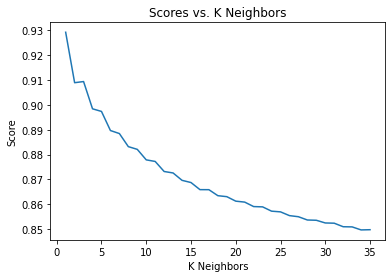

In [30]:
plt.plot(range(1,36), grid_classifier_tom.cv_results_['mean_test_score'])
plt.xlabel('K Neighbors')
plt.ylabel('Score')
plt.title('Scores vs. K Neighbors')
#grid_classifier2.cv_results_['mean_test_score']

**Final Attempt:** KNN still appears to be overfitting, so let's try other models and see whether I have more understandable accuracies. I found an article which talked about setting K to be n^1/2 for the n as the number of features, and I found another which talked about k = sqrt(N)/2 where N is the number of samples. I will try these and see whether it will make a difference. Since I have 60 features, 60^1/2 = is around 7.74, but round to odd number because I have two classes in the target. The other one will be sqrt(490000)/2 which is around 350, round to 351.

In [46]:
pipe_tom_2 = Pipeline(steps = [('scaler', scaler),('classifier', KNeighborsClassifier())])

search_space_tom_2 = [{'classifier__n_neighbors':[9, 351]}]

# grid cv
grid_classifier_tom_2 = GridSearchCV(pipe_tom_2, search_space_tom_2, cv=5, verbose = 1).fit(X_tom_train, Y_tom_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [47]:
grid_classifier_tom_2.score(X_tom_test, Y_tom_test)

0.8897054326776068

In [48]:
grid_classifier_tom_2.cv_results_['mean_test_score']

array([0.88209663, 0.80412292])

**Thoughts:** I believe KNN is still failing at it's task, so lets try other models for now. Logistic Regression and Decision Trees.

In [24]:
# scaler
logistic = LogisticRegression()

# pipe
pipe = Pipeline(steps = [('scaler', scaler),('classifier', logistic)])

search_space = [{'classifier__C': np.logspace(0,4,10),
                   'classifier__penalty': ['l1', 'l2']}]

# grid cv
grid_classifier = GridSearchCV(pipe, search_space, cv=5).fit(X_tom_train, Y_tom_train)

C:\Users\rahul\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rahul\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rahul\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 406, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\rahul\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py",

In [25]:
grid_classifier.score(X_tom_test, Y_tom_test)

0.7516664967893181

In [26]:
grid_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('classifier', LogisticRegression(C=7.742636826811269))],
 'verbose': False,
 'scaler': StandardScaler(),
 'classifier': LogisticRegression(C=7.742636826811269),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'classifier__C': 7.742636826811269,
 'classifier__class_weight': None,
 'classifier__dual': False,
 'classifier__fit_intercept': True,
 'classifier__intercept_scaling': 1,
 'classifier__l1_ratio': None,
 'classifier__max_iter': 100,
 'classifier__multi_class': 'auto',
 'classifier__n_jobs': None,
 'classifier__penalty': 'l2',
 'classifier__random_state': None,
 'classifier__solver': 'lbfgs',
 'classifier__tol': 0.0001,
 'classifier__verbose': 0,
 'classifier__warm_start': False}

**Thoughts:** Logistic regression has a solid 75% accuracy with the hyperparameters above.

In [31]:
pipe2 = Pipeline(steps = [('scaler', scaler),('classifier', DecisionTreeClassifier())])

search_space2 = [{'classifier__max_depth':list(range(1,6))}]

# grid cv
grid_classifier2 = GridSearchCV(pipe2, search_space2, cv=5, verbose = 1).fit(X_tom_train, Y_tom_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [32]:
grid_classifier2.score(X_tom_test, Y_tom_test)

0.7484354296198145

In [44]:
grid_classifier2.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('classifier', DecisionTreeClassifier(max_depth=5))],
 'verbose': False,
 'scaler': StandardScaler(),
 'classifier': DecisionTreeClassifier(max_depth=5),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'classifier__ccp_alpha': 0.0,
 'classifier__class_weight': None,
 'classifier__criterion': 'gini',
 'classifier__max_depth': 5,
 'classifier__max_features': None,
 'classifier__max_leaf_nodes': None,
 'classifier__min_impurity_decrease': 0.0,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__min_weight_fraction_leaf': 0.0,
 'classifier__random_state': None,
 'classifier__splitter': 'best'}

**Thoughts:** Decision Tree also has a solid 75% accuracy with the hyperparameters above, with a max_depth of 5. So either logistic regression or decision tree could be a good choice for the prediction model.

### Results of Milestone 3

Write a short overview/conclusion of the insights gained from your model building/evaluation.

I tried using three of the binary classification models to predict audience rating based on a couple of parameters and critic rating based on everything else. 

**Results of Audience Rating**
Without much need to transform data, I converted the necessary columns to dummy columns and split the test/train data effectively. Then I ran grid searches on decision tree, KNN, and logistic regression in order to get the best model for classification. For the audience rating, since there wasn't a large dimensionality, KNN had decent results, and decision trees/logistic regression had similar results. Luckily the KNN model wasn't overtrained for this particular chunk of the dataset, so I could pick an optimal K for clustering. 

**Results of Tomato Rating**
Data transformation was required for this particular task because the categories I wanted to pass in had high variability in terms of categories. For example, there were many unique directors, writers, and review publications. In order to reduce this variability and simplify the data, I bucketed the values by the frequency they appeared in, each bucketing system catered thoughtfully for each column. Then I converted the columns to dummy columns, and ran the models. Since there was a larger dimensionality for this dataset, still 500000 rows but 61 columns instead of 25 columns. Because of this large difference, KNN started to fail, and the initial number of neighbors were very overfit. Unfortunately, I moved on to using Logistic Regression and Decision Tree which both ended up having a similar result in accuracy. If I were to move this model to live, I would highly suggest using one of those two. They don't seem to be overfit.

# Confusion Matrices for the Best Models

**Feedback:** I needed to visualize the accuracy of the best models, so I included these after creating the models in Milestone 3.

### Audience Rating Confusion Matrix

In [3]:
final2 = pd.read_csv('reviews_final2.csv')

# getting dummy columns
audiencecol = ['runtimeMinutes','rating', 'first_genre']
audience_with_dum = pd.get_dummies(final2[audiencecol], columns = audiencecol[1:])
audience_with_dum['audienceRating'] = final2['audienceRating']

# split data for audience rating
X_aud = audience_with_dum.drop(['audienceRating'], axis=1)
Y_aud = audience_with_dum['audienceRating']
X_aud_train, X_aud_test, Y_aud_train, Y_aud_test = train_test_split(X_aud, Y_aud, test_size=0.2)

In [12]:
X_aud_train.head()

,runtimeMinutes,rating_NC-17,rating_PG,rating_PG-13,rating_R,rating_TVPG,first_genre_Action,first_genre_Adventure,first_genre_Biography,first_genre_Comedy,...,first_genre_History,first_genre_Holiday,first_genre_Horror,first_genre_Kids & family,first_genre_Musical,first_genre_Mystery & thriller,first_genre_Romance,first_genre_Sci-fi,first_genre_War,first_genre_Western
368082,100.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
85320,99.0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
288409,104.0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
62318,95.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
366802,141.0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# trying KNN
scaler = StandardScaler()
pipe2 = Pipeline(steps = [('scaler', scaler),('classifier', KNeighborsClassifier())])

search_space2 = [{'classifier__n_neighbors':list(range(1,11))}]

# grid cv
grid_classifier2 = GridSearchCV(pipe2, search_space2, cv=5, verbose = 1).fit(X_aud_train, Y_aud_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [5]:
grid_classifier2.score(X_aud_test, Y_aud_test)

0.7981857099174396

Text(0.5, 1.0, 'Scores vs. K Neighbors')

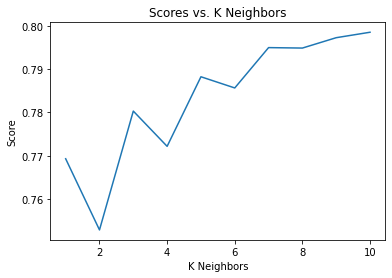

In [6]:
plt.plot(range(1,11), grid_classifier2.cv_results_['mean_test_score'])
plt.xlabel('K Neighbors')
plt.ylabel('Score')
plt.title('Scores vs. K Neighbors')

In [7]:
# confusion matrix
knn_pred = grid_classifier2.predict(X_aud_test)

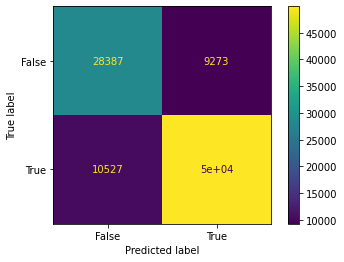

In [10]:
conf_matrix = confusion_matrix(Y_aud_test, knn_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

### Tomato Rating Confusion Matrix

In [16]:
tomato_with_dum = pd.read_csv('tomato_with_dum.csv').drop('Unnamed: 0', axis=1)
X_tom = tomato_with_dum.drop(['tomatoRating'], axis=1)
Y_tom = tomato_with_dum['tomatoRating']
X_tom_train, X_tom_test, Y_tom_train, Y_tom_test = train_test_split(X_tom, Y_tom, test_size=0.2)

In [18]:
# scaler
logistic = LogisticRegression()

# pipe
pipe = Pipeline(steps = [('scaler', scaler),('classifier', logistic)])

search_space = [{'classifier__C': np.logspace(0,4,10),
                   'classifier__penalty': ['l1', 'l2']}]

# grid cv
grid_classifier = GridSearchCV(pipe, search_space, cv=5).fit(X_tom_train, Y_tom_train)

C:\Users\rahul\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rahul\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rahul\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 406, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\rahul\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py",

In [19]:
grid_classifier.score(X_tom_test, Y_tom_test)

0.7515136071756192

In [23]:
log_pred = grid_classifier.predict(X_tom_test)

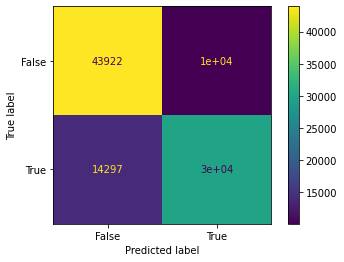

In [24]:
conf_matrix = confusion_matrix(Y_tom_test, log_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()